In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

import re
import sys
sys.path.append("../")
from functools import partial

from utils.dataset import SerializationDataset, OCRDataset
from models.generator import Seq2SeqGenerator, OCRSeq2SeqGenerator

import tensorflow as tf 
assert int(tf.__version__[:1]) < 2.0, "해당 코드는 1.x에서만 동작합니다."
tf.logging.set_verbosity(tf.logging.ERROR)

## 한글 Matplotlib 출력 세팅

In [2]:
# 1. 나눔 폰트를 다운받기
!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.font_manager as fm
# 2. 나눔 폰트의 위치 가져오기 
system_font = fm.findSystemFonts() # 현재 시스템에 설치된 폰트
nanum_fonts = [font for font in system_font if "NanumBarunGothic.ttf" in font]
font_path = nanum_fonts[0] # 설정할 폰트의 경로

# 3. 나눔 폰트로 설정하기
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc("font",family=font_name)

# 4. 폰트 재설정하기
fm._rebuild()

# 5. (optional) minus 기호 깨짐 방지
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

/bin/sh: apt-get: command not found
/bin/sh: apt-get: command not found


# \[ 2. MNIST 데이터셋 - SRN(Sequence Recognition Network) \]

MNIST 데이터셋을 통해 `SRN(Sequence Recognition Network)`을 학습시켜보도록 하겠습니다. SRN은 CRNN의 구조와 Seq2Seq, 그리고 Attention Network을 합친 모델입니다.

![Imgur](https://i.imgur.com/M11craN.png)

## 1. 데이터 가져오기 

In [3]:
# 단어 최소/최대 길이
min_words = 4
max_words = 8

df = pd.read_csv("../datasets/wordslist.txt",names=['word'])
df = df.drop_duplicates()
df = df[df.word.str.match(r'^[가-힣]+$')]
df = df[
    df.word.map(
        lambda x: (len(x) >= min_words) 
        and (len(x) <= max_words))]
words = df.word.values
np.random.shuffle(words)

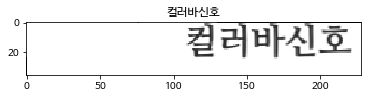

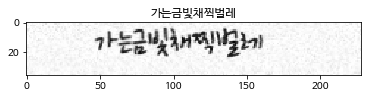

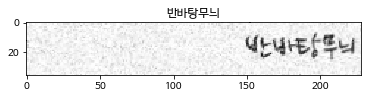

In [8]:
# OCRDataset setting
OCRDataset = partial(OCRDataset,
                     font_size=24,
                     bg_noise=0.2,
                     affine_noise=(0.0,0.01),
                     color_noise=(0.1,0.3),
                     normalize=False,
                     gray_scale=True)

dataset = OCRDataset(words)
images, labels = dataset[0:3]

for image, label in zip(images, labels):
    plt.title(label)
    plt.imshow(image[:,:,0],cmap='gray')
    plt.show()

## 2. 데이터 Generator 가져오기

In [9]:
# 단어 군을 기준으로 나누기 
# validation words는 5%만 둚
valid_words = words[:len(words)*5//100]
train_words = words[len(words)*5//100:]

valid_set = OCRDataset(valid_words)
train_set = OCRDataset(train_words)

train_gen = OCRSeq2SeqGenerator(train_set, batch_size=64)
valid_gen = OCRSeq2SeqGenerator(valid_set, batch_size=64)

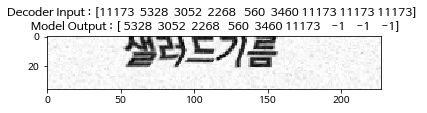

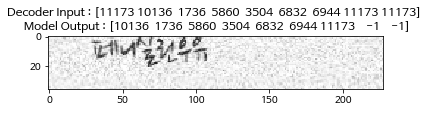

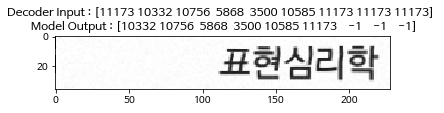

In [10]:
X,Y = train_gen[0]
for i in range(3):
    image = X['images'][i,:,:,0]
    dec_input = X['decoder_inputs'][i]
    
    output = Y['output_seqs'][i]

    plt.title(f"Decoder Input : {dec_input} \n Model Output : {output}")
    plt.imshow(image,cmap='gray')
    plt.show()

> 모델을 학습할 때에는 Images, Decoder Input, Model Output 이렇게 총 3개의 데이터가 필요합니다. Decoder input과 Model Output은 1번의 Time Step 만큼 차이가 납니다. 

----

# 3. 모델 구성하기



In [11]:
from models.layers import ConvFeatureExtractor, Map2Sequence 
from models.layers import BLSTMEncoder, CTCDecoder, DotAttention

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import concatenate

In [16]:
K.clear_session()

height = 36
num_classes = train_gen.num_classes
n_conv = 64 # the number of Convolution filter
n_lstm = 256 # the number of BLSM units
n_embed = 512 # the size of embedding vector
n_clf = 512 # the number of units in classifier Dense layer

# Image Encoder
inputs = Input(shape=(height, None, 1),name='images')
conv_maps = ConvFeatureExtractor(n_conv,
                                 name='feature_extractor')(inputs)
feature_seqs = Map2Sequence(name='map_to_sequence')(conv_maps)
states_encoder = BLSTMEncoder(n_units=n_lstm)(feature_seqs)    

# Embedding Layer
decoder_inputs = Input(shape=(None,), name='decoder_inputs')
embedding_layer = Embedding(num_classes+1, n_embed)
embedding_target = embedding_layer(decoder_inputs)

# Text Decoder
decoder_state_inputs = Input(shape=(n_lstm*2,), name='decoder_state')
gru_layer = GRU(n_lstm*2, 
                name='decoder_gru', 
                return_sequences=True)
states_decoder = gru_layer(embedding_target,
                           initial_state=decoder_state_inputs)

# Attention Layer
dotattend = DotAttention()
context, attention = dotattend([states_encoder, states_decoder])

# Classifier Layer
clf1_layer = Dense(n_clf, activation='relu')
clf2_layer = Dense(num_classes+1, activation='softmax',
                   name='output_seqs')

concat_output = concatenate([context, states_decoder], name='concat_output')
fc_outputs = clf1_layer(concat_output)
predictions = clf2_layer(fc_outputs)

## (8) 추론 모델과 학습 모델 구성하기

In [17]:
# For training
trainer = Model([inputs, 
                 decoder_inputs,
                 decoder_state_inputs], 
                predictions, name='trainer')

# For Inference
# - (1) Encoder
encoder = Model(inputs, states_encoder, 
                name='encoder')

# - (2) Decoder
states_encoder_input = Input((None,n_lstm*2), 
                             name='states_encoder_input')

context, attention = dotattend([states_encoder_input, states_decoder])
concat_output = concatenate([context, states_decoder], name='concat_output')
fc_outputs = clf1_layer(concat_output)
predictions = clf2_layer(fc_outputs)

decoder = Model([states_encoder_input,
                 decoder_inputs, 
                 decoder_state_inputs],
                [states_decoder,
                 predictions], name='decoder')

## (9) 학습 모델 Compile하기

In [18]:
from models.optimizer import AdamW
from models.losses import masking_sparse_categorical_crossentropy

In [19]:
y_true = tf.placeholder(shape=(None, None), dtype=tf.int32)

trainer.compile(AdamW(lr=1e-3),
                loss={"output_seqs":masking_sparse_categorical_crossentropy(-1)},
                target_tensors=[y_true])

In [22]:
trainer.summary()

Model: "trainer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 36, None, 1) 0                                            
__________________________________________________________________________________________________
feature_extractor (ConvFeatureE (None, 2, None, 512) 5551872     images[0][0]                     
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
map_to_sequence (Map2Sequence)  (None, None, 1024)   0           feature_extractor[0][0]          
____________________________________________________________________________________________

## (10) 모델 학습하기

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [24]:
callbacks =[]
rlrop = ReduceLROnPlateau(
    factor=0.5, patience=2, 
    min_lr=1e-6, verbose=1)
callbacks.append(rlrop)

epochs = 50

In [ ]:
hist = trainer.fit_generator(train_gen,
                             epochs=epochs,
                             validation_data=valid_gen,
                             callbacks=callbacks)

## (11) 모델 평가하기

In [ ]:
EOS_TOKEN = train_gen.num_classes + 1

In [ ]:
X,_ = test_gen[0]

# Target image 
target_images = X['images'][:10]

# Encoder 결과 계산
states_encoder_ = encoder.predict(target_images)

In [ ]:
# Decoder
batch_size = target_images.shape[0]

prev_inputs = np.ones((batch_size,1)) * EOS_TOKEN
prev_states = np.zeros((batch_size, 512))

In [ ]:
result = prev_inputs.copy()
while True:
    states_decoder_, predictions_ = decoder.predict({
        "states_encoder_input" : states_encoder_,
        "decoder_inputs": prev_inputs,
        "decoder_state": prev_states        
    })
    prev_states = states_decoder_[:,-1,:]
    prev_inputs = np.argmax(predictions_,axis=-1)
    
    if np.all(prev_inputs == EOS_TOKEN):
        break
    result = np.concatenate([result,prev_inputs],axis=-1)
result = result[:,1:].squeeze()

In [ ]:
for image, seq in zip(target_images,result):
    plt.title(seq)
    plt.imshow(image[:,:,0])
    plt.show()


Reference : [Attention based Seq2Seq in Keras](https://wanasit.github.io/attention-based-sequence-to-sequence-in-keras.html)